In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor(),
)

100%|██████████| 26421880/26421880 [00:23<00:00, 1110134.71it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 104174.28it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 642452.47it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9445440.50it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



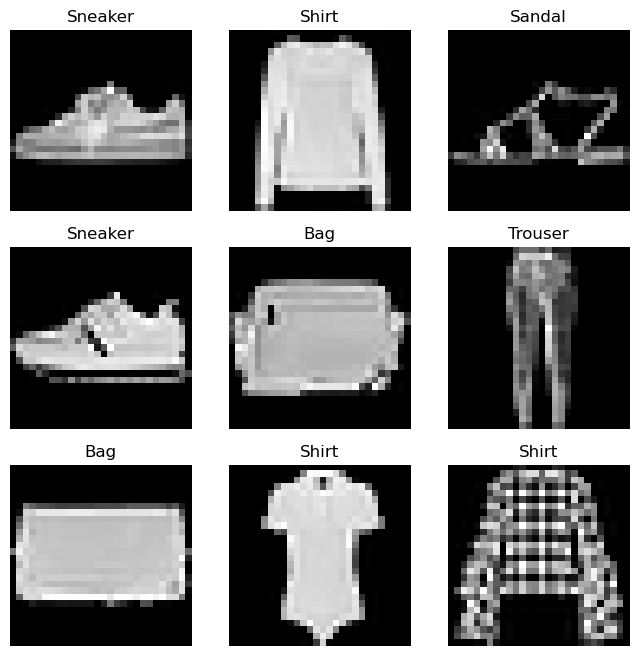

In [2]:
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1, )).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# DataLoader

DataLoader(dataset, batch_size = 1, shuffle = False, sampler = None, batch_sampler = None, num_workers = 0, collate_fn = None, pin_memory = False, drop_late = False, timeout = 0,
worker_init_fn = None, *, prefetch_factor = 2, persistent_workers = False)



In [3]:
total_size = len(training_data)
train_size, valid_size = int(total_size * 0.8), int(total_size * 0.2)

train_dataset, valid_dataset = torch.utils.data.random_split(training_data, [train_size, valid_size])

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 48000
Number of validation samples: 12000
Number of test samples: 10000


# Model(CNN)

In [13]:
from pytorch_lightning import LightningModule
import torch.nn as nn
import torch.optim as optim
import torchmetrics

class CNN(LightningModule):
    def __init__(self, num_classes, lr, dropout_ratio = 0.5):
        super().__init__()

        self.num_classes = num_classes
        self.lr = lr

        self.criterion = nn.CrossEntropyLoss()
        self.acc = torchmetrics.Accuracy(task='multiclass', num_classes = num_classes)

        self.layer = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
                nn.ReLU(),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout_ratio),
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout_ratio),
            )
        self.fc_layer = nn.Linear(64 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.layer(x)
        x = self.fc_layer(x.view(x.size(0), -1))
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        images, labels = batch
        if labels is None:
            return None

        outputs = self(images)

        loss = self.criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, dim = 1)
        acc = self.acc(predicted, labels)

        self.log('train_loss', loss, on_step=True, on_epoch=True, logger = True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger = True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)

        loss = self.criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, dim = 1)
        acc = self.acc(predicted, labels)

        self.log('val_loss', loss, on_step=True, on_epoch=True, logger = True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, logger = True)

        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)

        loss = self.criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, dim = 1)
        acc = self.acc(predicted, labels)

        self.log('test_loss', loss, on_step=True, on_epoch=True, logger = True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, logger = True)

        return loss

    def predict_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)

        _, predicted = torch.max(outputs.data, dim = 1)
        return predicted

In [6]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

model = CNN(num_classes=10, lr=0.001)

early_stopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=False, mode='min')
learning_rate_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = Trainer(
    max_epochs = 50,
    accelerator = 'auto',
    callbacks = [early_stopping, learning_rate_monitor],
    logger = TensorBoardLogger('lightning_logs', name='CNN')
)

trainer.fit(
    model,
    train_dataloader,
    valid_dataloader
)

trainer.test(model, test_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/CNN

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | CrossEntropyLoss   | 0      | train
1 | acc       | MulticlassAccuracy | 0      | train
2 | layer     | Sequential         | 64.5 K | train
3 | fc_layer  | Linear             | 5.8 K  | train
---------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.11/site-packages/torch/functional.py:910: UserWarning: MPS: _unique2 op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1716578890680/work/aten/src/ATen/native/mps/operations/Unique.mm:317.)
  output, inverse_indices, counts = torch._unique2(
/opt/anaconda3/lib/python3.11/site-packages/torchmetrics/functional/classification/accuracy.py:79: UserWarning: MPS: no support for int64 for sum_out_mps, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/run

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9067000150680542     │
│      test_loss_epoch      │     0.263920396566391     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.263920396566391, 'test_acc_epoch': 0.9067000150680542}]

# 라벨 유무 데이터 만들기

In [30]:
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset

train_dataset = datasets.FashionMNIST(
            root="data",
            train=True,
            download=False,
            transform=T.ToTensor(),
        )

total_size = len(train_dataset)
print(total_size)


60000


In [31]:
import random

batch_size = 32

batch_num = total_size // batch_size
labeled_batch_idx = random.choices(range(batch_num), k = int(batch_num * 0.1))

print(batch_num)
print(labeled_batch_idx)
print(len(labeled_batch_idx))

1875
[1642, 1009, 105, 884, 1784, 1482, 1006, 819, 1014, 213, 218, 1602, 1087, 478, 988, 1026, 1838, 1766, 338, 58, 1098, 1241, 1025, 1181, 773, 338, 530, 79, 1475, 884, 1380, 375, 1481, 1107, 1733, 668, 1377, 1861, 748, 459, 563, 656, 330, 283, 1600, 81, 207, 961, 474, 338, 1593, 582, 148, 376, 740, 1210, 1869, 456, 121, 1146, 601, 1151, 692, 819, 826, 1316, 67, 1003, 3, 1283, 213, 1433, 958, 1044, 1775, 244, 1084, 817, 1119, 388, 878, 1698, 15, 960, 1146, 247, 141, 280, 747, 614, 1486, 1285, 996, 1284, 500, 331, 897, 1084, 887, 313, 270, 1119, 244, 586, 1619, 1270, 1329, 1619, 248, 203, 1862, 1368, 1855, 402, 1620, 702, 673, 1610, 858, 679, 1668, 1125, 1130, 315, 953, 1789, 1459, 509, 221, 465, 9, 1626, 502, 350, 674, 921, 325, 838, 120, 1436, 1651, 1249, 1654, 1412, 1785, 1586, 774, 1471, 576, 651, 553, 957, 1007, 803, 36, 279, 551, 102, 1580, 1784, 728, 1640, 1017, 1307, 291, 1278, 477, 1064, 1751, 1259, 115, 979, 1206, 1474, 214, 1212, 976, 1544, 1524, 718, 489, 257, 1291, 1794, 8

In [41]:
batch_idx = -1

def collate_fn(batch):
    global batch_idx
    images, labels = zip(*batch)  # 배치 내 샘플을 이미지와 라벨로 분리

    batch_idx += 1
    if batch_idx in labeled_batch_idx:
        labels = torch.tensor(labels)  # 라벨 리스트를 배치 형태로 쌓음
    else:
        labels = None

    images = torch.stack(images, dim=0)  # 이미지 리스트를 배치 형태로 쌓음
    return images, labels



In [42]:
train_dataloader = DataLoader(dataset = train_dataset, shuffle= True, batch_size = batch_size, collate_fn = collate_fn)

In [45]:
unlabel_cnt = 0
label_cnt = 0
for data, label in train_dataloader:
    if label is None:
        label_cnt += 1
    else:
        unlabel_cnt += 1

print(label_cnt, unlabel_cnt)

1699 176


In [46]:
model = CNN(num_classes=10, lr=0.001)

trainer = Trainer(
    max_epochs = 30,
    accelerator = 'auto',
    callbacks = [learning_rate_monitor],
    logger = TensorBoardLogger('lightning_logs', name='CNN_unlabel_90')
)

trainer.fit(
    model,
    train_dataloader,
    valid_dataloader
)

trainer.test(model, test_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | CrossEntropyLoss   | 0      | train
1 | acc       | MulticlassAccuracy | 0      | train
2 | layer     | Sequential         | 64.5 K | train
3 | fc_layer  | Linear             | 5.8 K  | train
---------------------------------------------------------
70.3 K    Trainable params
0         Non-trainable params
70.3 K    Total params
0.281     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.10120000690221786    │
│      test_loss_epoch      │    2.2977445125579834     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 2.2977445125579834,
  'test_acc_epoch': 0.10120000690221786}]